In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylidc as pl
from project_config import env_config
from torch.utils.data import DataLoader
from data.dataset import PrecomputedNoduleROIs
import json
import seaborn as sns
import datetime as dt


from utils.visualisation import plot_val_error_distribution
from train.train import evaluate_model
from collections import Counter
from model.ResNet import load_resnet_model


nodule_df_path = env_config.nodule_df_file
nodule_processed_df_path = env_config.processed_nodule_df_file
hold_out_nodule_df_path = env_config.hold_out_nodule_df_file


nodule_df = pd.read_csv(nodule_df_path) # total nodules
nodule_df_processed = pd.read_csv(nodule_processed_df_path) # nodules that are processed and filtered
nodule_df_holdout = pd.read_csv(hold_out_nodule_df_path) # nodules that are holdout

# NOTE: this has filtered out some nodules that exceeds the scan border at max (70) bbox size.
# This is the dataframe that we used to develop the model
nodule_df_development = pd.concat([nodule_df_processed, nodule_df_holdout], axis=0)

divergent_cmap = 'RdBu'

plots_path = "report/plots"

The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension


## Distribution of annotations malignancy

In [6]:
nodule_df["cancer_label"].value_counts()

cancer_label
Ambiguous    1244
Benign        890
Malignant     491
Name: count, dtype: int64

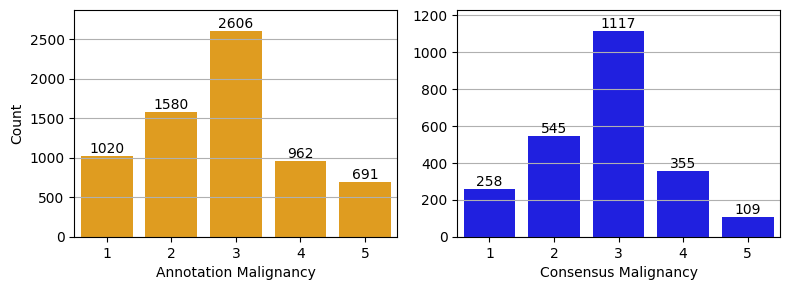

In [21]:
annotation_malignancy_counts = [
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 1).count(),
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 2).count(),
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 3).count(),
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 4).count(),
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 5).count(),
]

consensus_malignancy = nodule_df_development["malignancy_consensus"].value_counts().sort_index()

def plot_bar(x, y, xlabel, title, color, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    sns.barplot(x=x, y=y, color=color, ax=ax)
    for i, count in enumerate(y):
        ax.text(i, count, count, ha='center', va='bottom')
    ax.set_xlabel(xlabel)
    # ax.set_title(title)
    ax.grid(axis='y')
    ax.set_ylim(0, max(y) + (max(y) * 0.1))
    return ax

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
plot_bar([1,2,3,4,5], annotation_malignancy_counts, 'Annotation Malignancy', f'Annotation Malignancy Distribution\nTotal: {sum(annotation_malignancy_counts)}', "orange", ax=axes[0])
plot_bar([1,2,3,4,5], consensus_malignancy, 'Consensus Malignancy', f'Consensus Nodule Malignancy Distribution\nTotal: {sum(consensus_malignancy)}', "blue", ax=axes[1])
axes[0].set_ylabel('Count')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig(f'{plots_path}/malignancy_score_distribution.png')
plt.show()

# General EDA plot

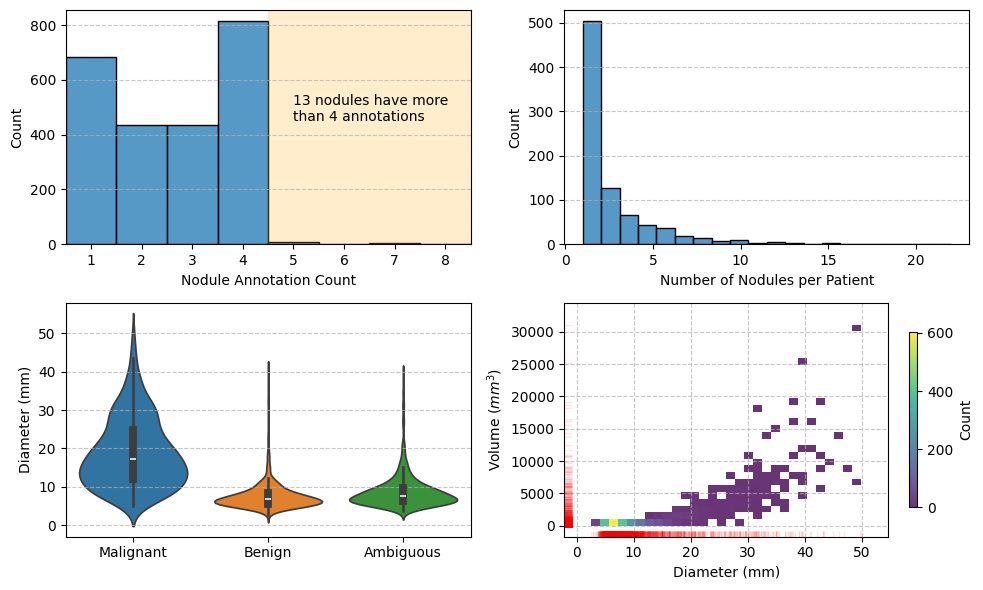

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

nodule_df_plot = nodule_df_development.copy()

# Nodule Annotation Count
ax = axes[0,0]
sns.histplot(data=nodule_df_plot, x="nodule_annotation_count", discrete=True, ax=ax)
ax.set_xticks(range(1, 9))
ax.set_xlabel("Nodule Annotation Count")
ax.text(5, 450, f"{sum(nodule_df_plot['nodule_annotation_count'] > 4)} nodules have more\nthan 4 annotations")
ax.set_xlim(0.5, 8.5)
ax.grid(axis="y", linestyle="--", alpha=0.7)
# color the right side of the plot
ax.axvspan(5-.5, 8+.5, color='orange', alpha=0.2)

ax = axes[0,1]
sns.histplot(nodule_df_plot.groupby("scan_id").size(), bins=20, ax=ax)
ax.set_xlabel("Number of Nodules per Patient")
ax.grid(axis="y", linestyle="--", alpha=0.7)

ax = axes[1,0]
sns.violinplot(data=nodule_df_plot, x="cancer_label", y="ann_mean_diameter", hue="cancer_label", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Diameter (mm)")
ax.grid(axis="y", linestyle="--", alpha=0.7)

ax = axes[1,1]
sns.histplot(data=nodule_df_plot, x="ann_mean_diameter", y="ann_mean_volume", bins=30, cbar=True, cbar_kws=dict(shrink=0.75, label="Count"), cmap="viridis", alpha=0.8, ax=ax)
sns.rugplot(data=nodule_df_plot, x="ann_mean_diameter", y="ann_mean_volume", color="red", alpha=0.1, ax=ax)
# ax.title("Bivariate Distribution of Nodule Diameter and Volume")
ax.set_ylabel("Volume $(mm^3)$")
ax.set_xlabel("Diameter (mm)")
ax.set_ylim(bottom=-1700)
ax.grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("report/plots/nodule_eda.png")
plt.show()

# Showcase few nodules

[INFO|dataset.py|__init__|L231] 2024-12-04 15:51:28: 
            Precomputed nodule dataset loaded successfully with parameters:
            Precomputed directory path: data/precomputed_resampled_rois_70C_2.5D
            Number of nodules: 2113 
            Data shape: torch.Size([3, 70, 70])
            Data augmentation: False
            


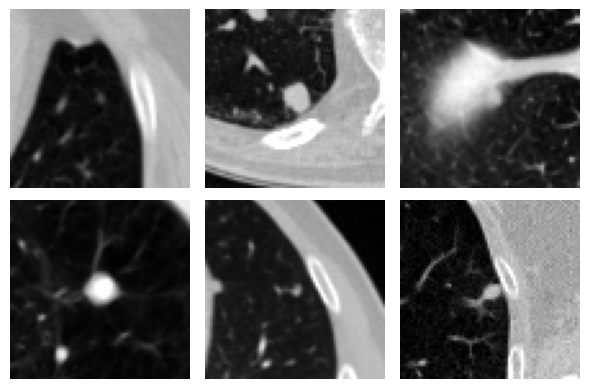

In [ ]:
c70 = PrecomputedNoduleROIs(
    "data/precomputed_resampled_rois_70C_2.5D",
    data_augmentation=False,
    dimensionality="2.5D",
    center_mask_size=None,
)
n_examples = 6
loader = DataLoader(c70, batch_size=n_examples, shuffle=True)
feature, labels, nodule_ids = next(iter(loader))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 4))
for i in range(n_examples):
    if i < 3:
        ax = axes[0][i]
    else:
        ax = axes[1][i-3]
    middle_slice = 1
    ax.imshow(feature[i, middle_slice], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(f'{plots_path}/few_nodule_examples.png')
plt.show()

[INFO|dataset.py|__init__|L231] 2024-12-04 17:38:33: 
            Precomputed nodule dataset loaded successfully with parameters:
            Precomputed directory path: data/precomputed_resampled_rois_30C_2.5D
            Number of nodules: 2113 
            Data shape: torch.Size([3, 30, 30])
            Data augmentation: False
            
[INFO|dataset.py|__init__|L231] 2024-12-04 17:38:33: 
            Precomputed nodule dataset loaded successfully with parameters:
            Precomputed directory path: data/precomputed_resampled_rois_50C_2.5D
            Number of nodules: 2113 
            Data shape: torch.Size([3, 50, 50])
            Data augmentation: False
            
[INFO|dataset.py|__init__|L231] 2024-12-04 17:38:33: 
            Precomputed nodule dataset loaded successfully with parameters:
            Precomputed directory path: data/precomputed_resampled_rois_70C_2.5D
            Number of nodules: 2113 
            Data shape: torch.Size([3, 70, 70])
            

/var/folders/_c/vr22_fg12d7flyy_ll_m264w0000gp/T/ipykernel_61812/1968690247.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


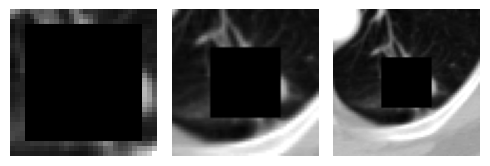

In [ ]:
c30 = PrecomputedNoduleROIs(
    "data/precomputed_resampled_rois_30C_2.5D",
    data_augmentation=False,
    dimensionality="2.5D",
    center_mask_size=25,
)
c50 = PrecomputedNoduleROIs(
    "data/precomputed_resampled_rois_50C_2.5D",
    data_augmentation=False,
    dimensionality="2.5D",
    center_mask_size=25,
)
c70 = PrecomputedNoduleROIs(
    "data/precomputed_resampled_rois_70C_2.5D",
    data_augmentation=False,
    dimensionality="2.5D",
    center_mask_size=25,
)

c30l = DataLoader(c30, batch_size=1, shuffle=False)
c50l = DataLoader(c50, batch_size=1, shuffle=False)
c70l = DataLoader(c70, batch_size=1, shuffle=False)

c30f, _, _ = next(iter(c30l))
c50f, _, _ = next(iter(c50l))
c70f, _, _ = next(iter(c70l))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 1.8), constrained_layout=True)
for i, batch in enumerate([c30f, c50f, c70f]):
    feature = batch[0][1]
    axes[i].imshow(feature, cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(f'{plots_path}/nodule_masked_examples.png')
plt.show()

# Nodule Features Correlation Plot
We reorder the values of the features that do not reflect a natural scale. These are:
- calcification

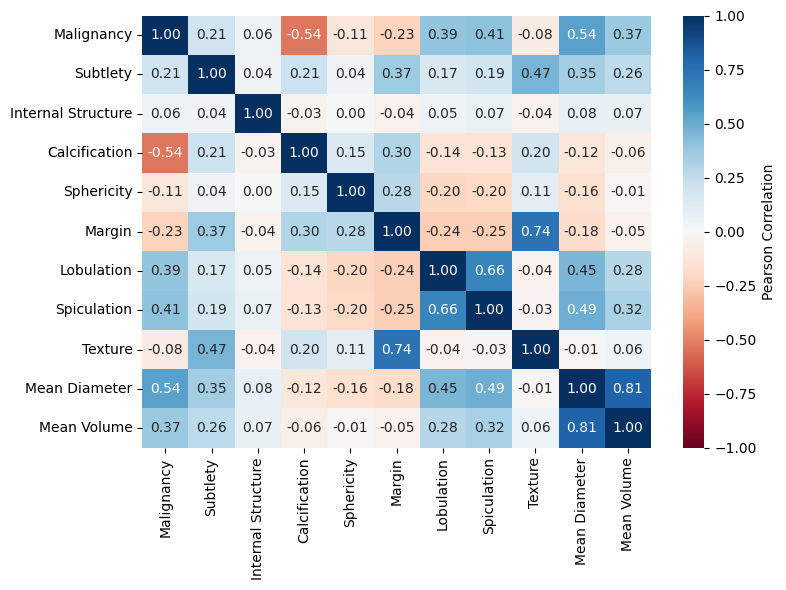

In [69]:

nodule_df_plot = nodule_df[["malignancy_consensus", "subtlety_consensus", "internalStructure_consensus", "calcification_consensus", "sphericity_consensus", "margin_consensus", "lobulation_consensus", "spiculation_consensus", "texture_consensus", "ann_mean_diameter", "ann_mean_volume"]].copy()


# excluded:
# internalStructure_consensus

"""
new order of calcification:
1. abscent
2. non-central
3. central
4. solid
5. laminated
6. popcorn
"""
calcification_mapping = {6:1, 1:6, 2:5, 3:4, 4:2, 5:3}

nodule_df_plot["calcification_consensus"] = nodule_df_plot["calcification_consensus"].map(calcification_mapping)

# rename columns
nodule_df_plot.columns = [col.replace('_consensus', '').capitalize() for col in nodule_df_plot.columns]
nodule_df_plot = nodule_df_plot.rename(columns={"Ann_mean_diameter": "Mean Diameter", "Ann_mean_volume": "Mean Volume", "Internalstructure": "Internal Structure"})

# plot a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(nodule_df_plot.corr(method="pearson"), annot=True, fmt=".2f", cmap=divergent_cmap, cbar=True, vmin=-1, vmax=1, cbar_kws={"label": "Pearson Correlation"})
plt.tight_layout()
plt.savefig(f'{plots_path}/nodule_correlation_heatmap.png')
plt.show()

## Training Fold Results Plot

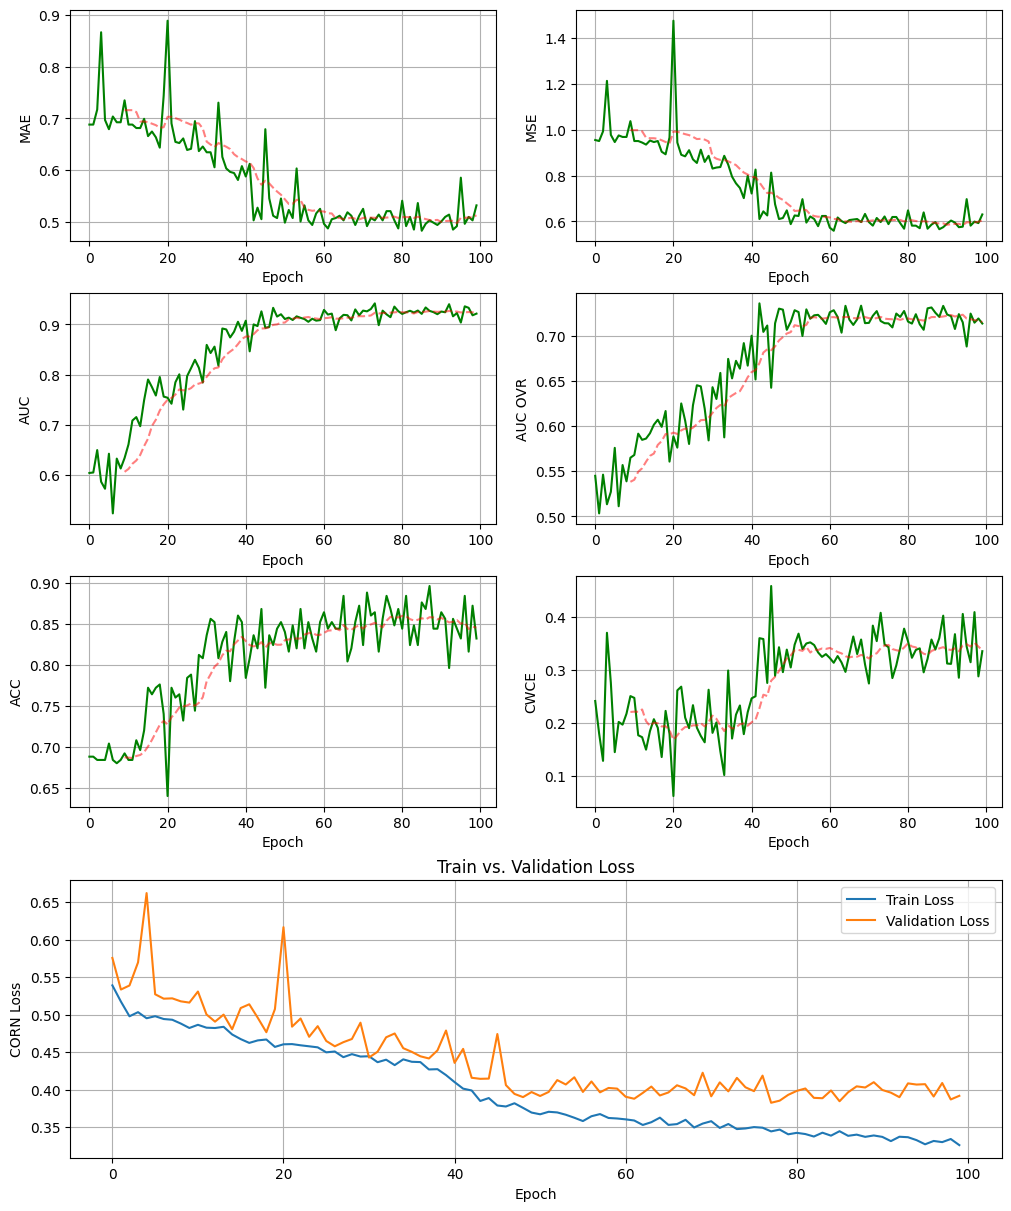

In [2]:
from utils.visualisation import plot_fold_results
plot_fold_results("c50_3D_2411_1831", fold_num=0, epochs_dampen=0, save_path=f"{plots_path}/example_fold_results.png")

## Model Performance Trend for different context windows plot

In [191]:
def get_results_df(experiment_ids: list[str]) -> pd.DataFrame:
    local_user = "newuser"
    results = {}
    for e in experiment_ids:
        local_exp_path = f"/Users/{local_user}/Documents/ITU/master_thesis/hpc/jobs/{e}"
        with open(f"{local_exp_path}/run_{e}.json") as f:
            config = json.load(f)
        results[e] = config

    # get aggregated results from all folds
    dataframes = []
    for exp in experiment_ids:
        info = exp.split("_")
        context = info[0]
        dimensionality = info[1]
        all_fold_results = {
            "ACC": [], # binary accuracy
            "AUC": [], # binary auc
            "AUC OVR": [],
            "MAE": [],
            "MSE": [],
            "CWCE": [],
        }
        for fold in results[exp]["fold_results"]:
            # TODO use the metrics for the best loss
            best_loss_epoch = fold["best_loss_epoch"] - 1 # saved as 1-indexed
            # best_loss_epoch = -1 # use the last epoch

            val_auc_filtered = fold["val_AUC_filtered"][best_loss_epoch]
            val_auc_ovr = fold["val_AUC_ovr"][best_loss_epoch]
            val_mae = fold["val_maes"][best_loss_epoch]
            val_mse = fold["val_mses"][best_loss_epoch]
            val_cwce = fold["val_cwces"][best_loss_epoch]
            val_accuracy = fold["val_binary_accuracies"][best_loss_epoch]

            all_fold_results["AUC"].append(val_auc_filtered) # binary auc
            all_fold_results["AUC OVR"].append(val_auc_ovr)
            all_fold_results["MAE"].append(val_mae)
            all_fold_results["MSE"].append(val_mse)
            all_fold_results["CWCE"].append(val_cwce)
            all_fold_results["ACC"].append(val_accuracy) # binary accuracy

        agg_results = {}
        for k, v in all_fold_results.items():
            agg_results[k] = context, dimensionality, np.mean(v), np.std(v)

        results_df = pd.DataFrame.from_dict(agg_results, orient="index", columns=["context", "dim", "mean", "std"])
        dataframes.append(results_df)

    results_df = pd.concat(dataframes).reset_index().rename(columns={"index": "metric"})
    return results_df

experiments_25D = [
    "c20_25D_2411_1631",
    "c30_25D_2411_1543",
    "c40_25D_2411_1640",
    "c50_25D_2411_1812",
    "c60_25D_2411_1641",
    "c70_25D_2411_1705",
]
experiments_3D = [
    "c20_3D_2511_0013",
    "c30_3D_2411_1947",
    "c40_3D_2511_1536",
    "c50_3D_2411_1831",
    "c60_3D_2511_2027",
    "c70_3D_2411_1824",
]

agg_results_25D = get_results_df(experiments_25D)
agg_results_3D = get_results_df(experiments_3D)

print("25D")
display(agg_results_25D)

print("3D")
display(agg_results_3D)

25D


,metric,context,dim,mean,std
0,ACC,c20,25D,0.799619,0.014946
1,AUC,c20,25D,0.914806,0.017861
2,AUC OVR,c20,25D,0.715784,0.020353
3,MAE,c20,25D,0.524977,0.027898
4,MSE,c20,25D,0.651111,0.042262
5,CWCE,c20,25D,0.345971,0.046392
6,ACC,c30,25D,0.815397,0.041187
7,AUC,c30,25D,0.911464,0.012075
8,AUC OVR,c30,25D,0.725371,0.015695
9,MAE,c30,25D,0.500812,0.034704


3D


,metric,context,dim,mean,std
0,ACC,c20,3D,0.804069,0.024199
1,AUC,c20,3D,0.916607,0.027119
2,AUC OVR,c20,3D,0.731427,0.022429
3,MAE,c20,3D,0.493141,0.020077
4,MSE,c20,3D,0.593317,0.044254
5,CWCE,c20,3D,0.341266,0.015584
6,ACC,c30,3D,0.820686,0.043850
7,AUC,c30,3D,0.903002,0.025152
8,AUC OVR,c30,3D,0.729291,0.018351
9,MAE,c30,3D,0.475882,0.030650


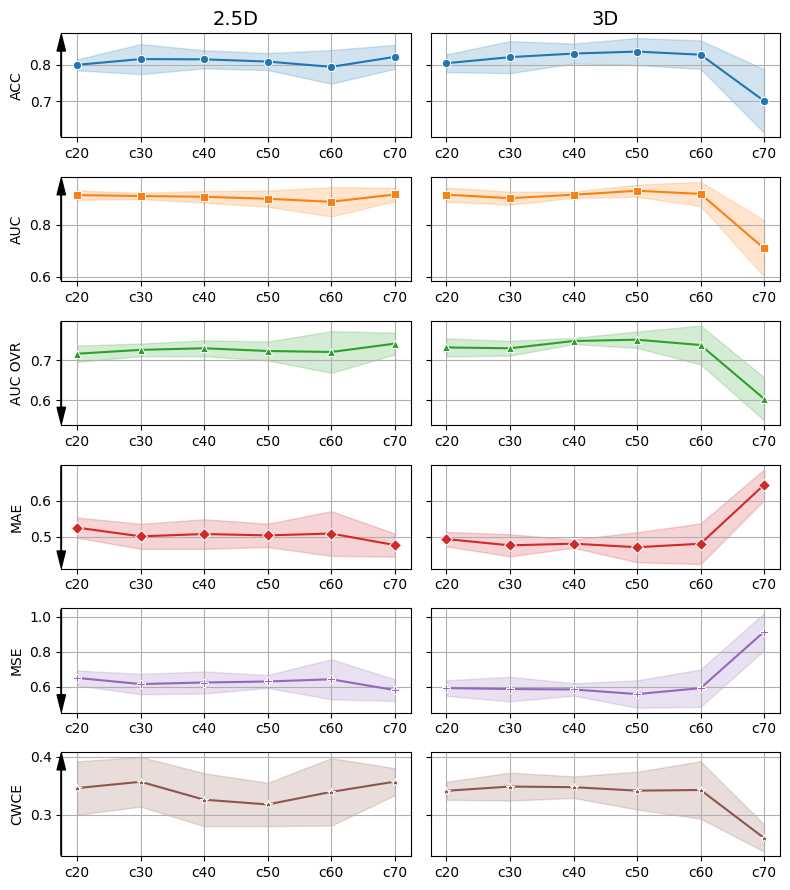

In [193]:
def performance_trend_plot(agg_results_25D: pd.DataFrame, agg_results_3D: pd.DataFrame, save_path: str | None = None):
    n_metrics = agg_results_25D["metric"].nunique()
    _, axes = plt.subplots(nrows=n_metrics, ncols=2, figsize=(8, 9), sharey="row")

    markers = ['o', 's', '^', 'D', 'P', '*']
    colors = sns.color_palette("tab10")

    for i, metric in enumerate(agg_results_25D["metric"].unique()):
        metric_25D = agg_results_25D[agg_results_25D["metric"] == metric]
        metric_3D = agg_results_3D[agg_results_3D["metric"] == metric]

        # 25D
        ax = axes[i, 0]
        if i == 0: # first row
            ax.set_title("2.5D", fontsize=14)

        sns.lineplot(x="context", y="mean", data=metric_25D, ax=ax, marker=markers[i], color=colors[i])
        ax.fill_between(
            x=metric_25D["context"],
            y1=metric_25D["mean"] - metric_25D["std"],
            y2=metric_25D["mean"] + metric_25D["std"],
            color=colors[i],
            alpha=0.2,
        )
        ax.set_ylabel(metric.upper())
        ax.set_xlabel("")
        ax.grid(True)


        # 3D
        ax = axes[i, 1]
        if i == 0: # first row
            ax.set_title("3D", fontsize=14)

        sns.lineplot(x="context", y="mean", data=metric_3D, ax=ax, marker=markers[i], color=colors[i])
        ax.fill_between(
            metric_3D["context"],
            metric_3D["mean"] - metric_3D["std"],
            metric_3D["mean"] + metric_3D["std"],
            color=colors[i],
            alpha=0.2,
        )
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.grid(True)

    for i, ax in enumerate(axes.flatten()):
        if i % 2 == 0:
            if i in [0, 2, 10]:
                # arrow points up
                ax.annotate('', xy=(0, 1), xytext=(0, 0),
                    arrowprops=dict(facecolor='black', shrink=0.01, width=.2, headwidth=6),
                    color='black', xycoords='axes fraction', textcoords='axes fraction',
                    rotation=90, va='center', ha='right')
            else:
                # arrow points down
                ax.annotate('', xy=(0, 0), xytext=(0, 1),
                    arrowprops=dict(facecolor='black', shrink=0.01, width=.2, headwidth=6),
                    color='black', xycoords='axes fraction', textcoords='axes fraction',
                    rotation=90, va='center', ha='right')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

performance_trend_plot(agg_results_25D, agg_results_3D, save_path=f"{plots_path}/performance_trend_plot.png")

25D Masked


,metric,context,dim,mean,std
0,ACC,c30,25D,0.638862,0.035996
1,AUC,c30,25D,0.648905,0.051153
2,AUC OVR,c30,25D,0.565404,0.031742
3,MAE,c30,25D,0.675881,0.029131
4,MSE,c30,25D,0.973987,0.041271
5,CWCE,c30,25D,0.249271,0.034323
6,ACC,c40,25D,0.638862,0.035996
7,AUC,c40,25D,0.540929,0.074876
8,AUC OVR,c40,25D,0.509821,0.020537
9,MAE,c40,25D,0.673538,0.019773


3D Masked


,metric,context,dim,mean,std
0,ACC,c30,3D,0.638862,0.035996
1,AUC,c30,3D,0.576197,0.085858
2,AUC OVR,c30,3D,0.517623,0.035431
3,MAE,c30,3D,0.676815,0.007267
4,MSE,c30,3D,0.977230,0.021978
5,CWCE,c30,3D,0.234784,0.024276
6,ACC,c40,3D,0.646964,0.042079
7,AUC,c40,3D,0.651241,0.096574
8,AUC OVR,c40,3D,0.567202,0.018712
9,MAE,c40,3D,0.675637,0.020921


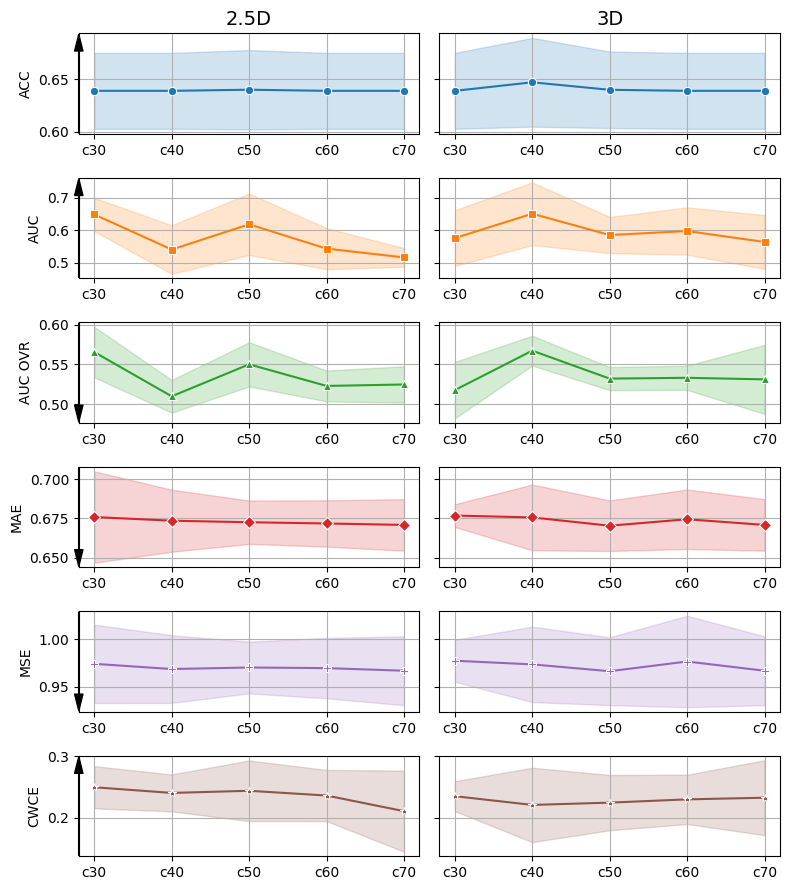

In [7]:
# FOR MASKED EXPERIMENTS
experiments_25D_masked = [
    "c30_25D_2911_1126",
    "c40_25D_2811_2153",
    "c50_25D_2811_2112",
    "c60_25D_2811_2111",
    "c70_25D_2811_2106"
]
experiments_3D_masked = [
    "c30_3D_2911_1118",
    "c40_3D_0112_2132",
    "c50_3D_2911_1631",
    "c60_3D_2911_1630",
    "c70_3D_2911_1131",
]

agg_results_25D_masked = get_results_df(experiments_25D_masked)
agg_results_3D_masked = get_results_df(experiments_3D_masked)

print("25D Masked")
display(agg_results_25D_masked)

print("3D Masked")
display(agg_results_3D_masked)

performance_trend_plot(agg_results_25D_masked, agg_results_3D_masked, save_path=f"{plots_path}/performance_trend_plot_masked.png")

**NOTE**: the errorbar in the plot above is 1 whole std both above and below the line.

# Error Distribution
(assumes that a holdout set is precomputed)

1. Load precomputed holdout nodule dataset
2. load model weights
3. run model evaluation using the holdout nodules

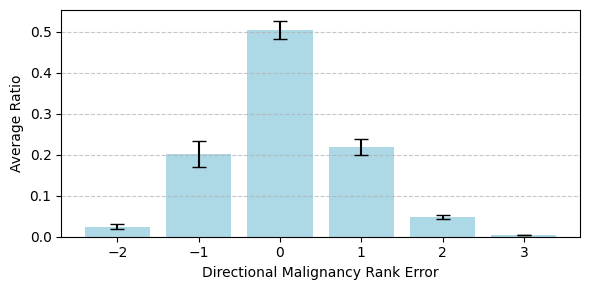

In [103]:
with open(f"model/model_benchmark_results.json") as f:
    benchmark_results = json.load(f)

# experiment_id = "c50_3D_2411_1831" # best performing model
experiment_id = "c30_3D_2411_1947" # best performing model
folds = ["0", "1", "2", "3", "4"]

res = {}
for f in folds:
    fold_res = benchmark_results[experiment_id][f]
    error_ratios = pd.Series(fold_res["fold_errors"]).value_counts(normalize=True).sort_index()
    res[f] = error_ratios

errors_df = pd.DataFrame(res)
mean_values = errors_df.mean(axis=1)
std_values = errors_df.std(axis=1)

plt.figure(figsize=(6, 3))
plt.bar(mean_values.index, mean_values, yerr=std_values, capsize=5, color='lightblue')
plt.xlabel('Directional Malignancy Rank Error')
plt.ylabel('Average Ratio')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{plots_path}/holdout_error_distribution.png")
plt.show()

# Benchmark table
benchmarks are computed with the `model/benchmark.py` script

In [3]:
with open("model/model_benchmark_results.json", "r") as f:
    benchmark_results = json.load(f)

experiments = [
    "c30_25D_2411_1543",
    "c50_25D_2411_1812",
    "c70_25D_2411_1705",
    "c30_3D_2411_1947",
    "c50_3D_2411_1831",
    "c70_3D_2411_1824",
]
folds = [0, 1, 2, 3, 4]

metrics = {}
for e in experiments:
    exp_results = benchmark_results[e]
    exp_aucs = [] # binary
    exp_accs = [] # binary
    exp_mae = []
    exp_mse = []
    exp_cwce = []
    for f in folds:
        fold_results = exp_results[str(f)]
        exp_aucs.append(fold_results["AUC_filtered"])
        exp_accs.append(fold_results["binary_accuracy"])
        exp_mae.append(fold_results["mae"])
        exp_mse.append(fold_results["mse"])
        exp_cwce.append(fold_results["cwce"])

    metrics[e] = {
        "AUC_mean": np.mean(exp_aucs),
        "AUC_std": np.std(exp_aucs),
        "ACC_mean": np.mean(exp_accs),
        "ACC_std": np.std(exp_accs),
        "MAE_mean": np.mean(exp_mae),
        "MAE_std": np.std(exp_mae),
        "MSE_mean": np.mean(exp_mse),
        "MSE_std": np.std(exp_mse),
        "CWCE_mean": np.mean(exp_cwce),
        "CWCE_std": np.std(exp_cwce),
    }

# make dataframe
df = pd.DataFrame.from_dict(metrics, orient="index")
df_mean = df[[c for c in df.columns if "mean" in c]].round(3)
df_std = df[[c for c in df.columns if "std" in c]].round(3)
display(df_mean)
display(df_std[["AUC_std", "ACC_std"]])

# print(df_mean.to_latex(index=True))

,AUC_mean,ACC_mean,MAE_mean,MSE_mean,CWCE_mean
c30_25D_2411_1543,0.896,0.777,0.590,0.768,0.368
c50_25D_2411_1812,0.862,0.765,0.604,0.803,0.343
c70_25D_2411_1705,0.859,0.765,0.585,0.787,0.385
c30_3D_2411_1947,0.889,0.783,0.575,0.739,0.369
c50_3D_2411_1831,0.885,0.780,0.565,0.754,0.363
c70_3D_2411_1824,0.686,0.659,0.766,1.123,0.270


,AUC_std,ACC_std
c30_25D_2411_1543,0.017,0.022
c50_25D_2411_1812,0.007,0.024
c70_25D_2411_1705,0.026,0.033
c30_3D_2411_1947,0.015,0.020
c50_3D_2411_1831,0.018,0.029
c70_3D_2411_1824,0.123,0.077


# Plot of time it took to train different context models

/var/folders/_c/vr22_fg12d7flyy_ll_m264w0000gp/T/ipykernel_15708/3394980353.py:67: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 150)


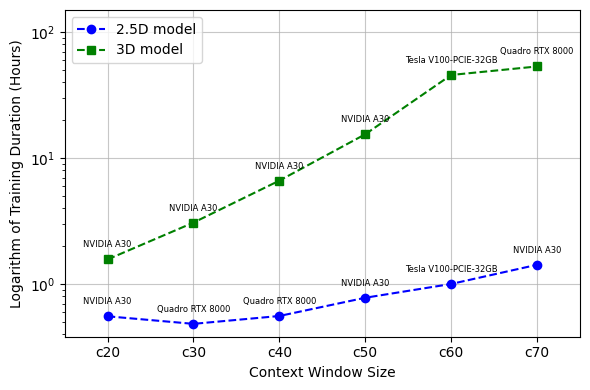

In [73]:
experiments_25d = [
    "c20_25D_2411_1631",
    "c30_25D_2411_1543",
    "c40_25D_2411_1640",
    "c50_25D_2411_1812",
    "c60_25D_2411_1641",
    "c70_25D_2411_1705",
]

experiments_3d = [
    "c20_3D_2511_0013",
    "c30_3D_2411_1947",
    "c40_3D_2511_1536",
    "c50_3D_2411_1831",
    "c60_3D_2511_2027",
    "c70_3D_2411_1824",
]

def get_durations(experiment_ids: list[str]) -> list[int]:
    durations = []
    gpu_used = []
    for exp in experiment_ids:
        with open(f"hpc/jobs/{exp}/run_{exp}.json") as f:
            config = json.load(f)

        gpu_name = config["training"]["gpu_used"]
        gpu_used.append(gpu_name)
        duration = config["duration"]

        split = duration.split(":")
        if "day" in split[0]:
            days = split[0].split(" ")[0]
            hours = split[0].split(" ")[-1]
            minutes, rest = split[1:]
            seconds, microsec = rest.split(".")
            duration = dt.timedelta(days=int(days), hours=int(hours), minutes=int(minutes), seconds=int(seconds), microseconds=int(microsec))
        else:
            hours, minutes, rest = split
            seconds, microsec = rest.split(".")
            duration = dt.timedelta(hours=int(hours), minutes=int(minutes), seconds=int(seconds), microseconds=int(microsec))

        # convert to hours
        duration = duration.total_seconds() / 3600
        durations.append(duration)
    return durations, gpu_used

durations25d, gpu_used25d = get_durations(experiments_25d)
durations3d, gpu_used3d = get_durations(experiments_3d)

# plot the time taken for each experiment
plt.figure(figsize=(6, 4))
plt.plot(experiments_25d, durations25d, color="blue", marker="o", label="2.5D model", linestyle="--")
plt.plot(experiments_25d, durations3d, color="green", marker="s", label="3D model", linestyle="--")

# add the gpu used
gpu_fontsize = 6
for i, (gpu25d, gpu3d) in enumerate(zip(gpu_used25d, gpu_used3d)):
    plt.text(i, durations25d[i] + (durations25d[i] * 0.2), gpu25d, ha="center", va="bottom", fontsize=gpu_fontsize)
    plt.text(i, durations3d[i] + (durations3d[i] * 0.2), gpu3d, ha="center", va="bottom", fontsize=gpu_fontsize)

plt.xlabel("Context Window Size")
plt.xticks(ticks=[0,1,2,3,4,5],labels=["c20", "c30", "c40", "c50", "c60", "c70"])
plt.xlim(-0.5, 5.5)

plt.ylabel("Logarithm of Training Duration (Hours)")
plt.yscale("log")
plt.ylim(0, 150)

plt.legend(loc="upper left")
plt.grid(alpha=0.7)
plt.tight_layout()
plt.savefig(f"{plots_path}/experiment_durations.png")
plt.show()

# Plot to show trend of the average confidence between different context models models

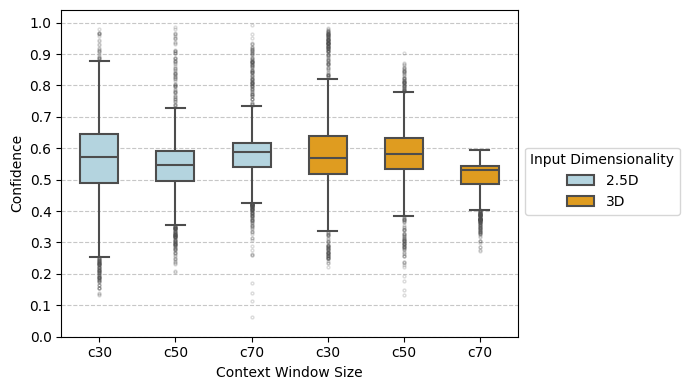

In [101]:
experiments = [
    "c30_25D_2411_1543",
    "c50_25D_2411_1812",
    "c70_25D_2411_1705",
    "c30_3D_2411_1947",
    "c50_3D_2411_1831",
    "c70_3D_2411_1824",
]

confidences = {}
for e in experiments:
    preds_df = pd.read_csv(f"model/predictions/{e}/pred_nodule_df_fold0.csv")
    confidences[e] = preds_df["confidence"]

confidences_df = pd.DataFrame.from_dict(confidences)
confidences_df = confidences_df.melt(var_name='model', value_name='score')
confidences_df['hue'] = confidences_df['model'].apply(
    lambda x: '2.5D' if '25D' in x else '3D'
)

plt.figure(figsize=(7, 4))
sns.boxplot(data=confidences_df, x='model', y='score', hue='hue', palette={'2.5D': 'lightblue', '3D': 'orange'}, width=.5, linewidth=1.5, fliersize=2, flierprops={'alpha': 0.2})
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Context Window Size")
plt.xticks(ticks=range(6), labels=["c30", "c50", "c70", "c30", "c50", "c70"])
plt.ylabel("Confidence")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(title="Input Dimensionality", bbox_to_anchor=(1, 0.6), loc='upper left')
plt.tight_layout()
plt.savefig(f"{plots_path}/confidence_boxplot.png")
plt.show()

# TODO should this also be plotted for the masked experiments?

# How noisy are the annotations labels?

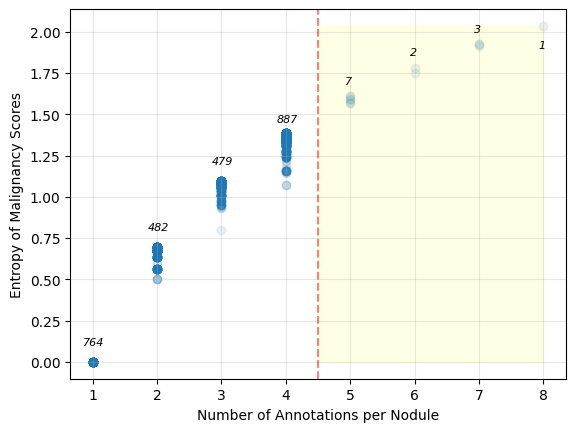

In [10]:
import ast
import numpy as np
from scipy.stats import entropy
from collections import Counter

nodule_df = pd.read_csv(nodule_df_path)
# TODO use the color to represent the number of annotations

malignancy_scores = nodule_df[
    f"malignancy_scores"
].apply(ast.literal_eval)

std = [np.std(x) for x in malignancy_scores]
ent = [entropy(x) for x in malignancy_scores]
n_annotations = [len(x) for x in malignancy_scores]
c_annotations = Counter(n_annotations)

plt.scatter(n_annotations, ent, alpha=0.1)
plt.xlabel("Number of Annotations per Nodule")
plt.ylabel("Entropy of Malignancy Scores")
plt.grid(alpha=0.3)
plt.axvline(x=4.5, color='r', linestyle='--', alpha=0.5, label="Cut-off")
plt.fill_between([4.5, 8], 0, max(ent), color='yellow', alpha=0.1)

# Annotate the number of nodules with a specific number of annotations
size = 8
color = "black"
weight = "bold"
style = "italic"
plt.text(0.85, 0.10, f"{c_annotations[1]}", fontsize=size, style=style)
plt.text(1.85, 0.80, f"{c_annotations[2]}", fontsize=size, style=style)
plt.text(2.85, 1.20, f"{c_annotations[3]}", fontsize=size, style=style)
plt.text(3.85, 1.45, f"{c_annotations[4]}", fontsize=size, style=style)
plt.text(4.92, 1.68, f"{c_annotations[5]}", fontsize=size, style=style)
plt.text(5.92, 1.86, f"{c_annotations[6]}", fontsize=size, style=style)
plt.text(6.92, 2, f"{c_annotations[7]}", fontsize=size, style=style)
plt.text(7.92, 1.90, f"{c_annotations[8]}", fontsize=size, style=style)
plt.show()

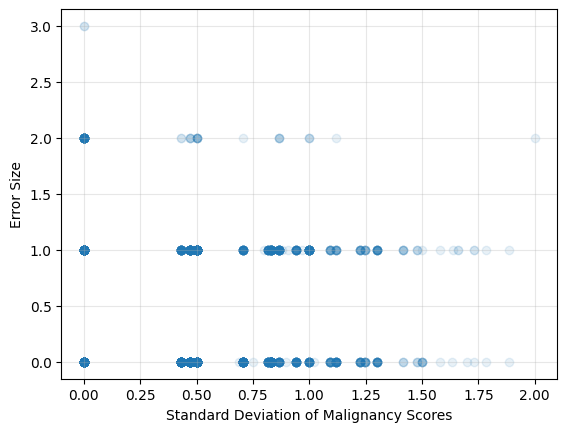

In [ ]:
# plot the error size vs the std of the malignancy scores
import ast
preds_df = pd.read_csv("model/predictions/c50_3D_2411_1831/pred_nodule_df_fold0.csv")
preds_df["malignancy_scores"] = preds_df["malignancy_scores"].apply(ast.literal_eval)

preds_df["error_size"] = abs(preds_df["pred"] - preds_df["malignancy_consensus"])
preds_df["malignancy_std"] = preds_df["malignancy_scores"].apply(np.std)

plt.scatter(preds_df["malignancy_std"], preds_df["error_size"], alpha=0.1)
plt.xlabel("Standard Deviation of Malignancy Scores")
plt.ylabel("Error Size")
plt.grid(alpha=0.3)
plt.show()

# Embedding plots

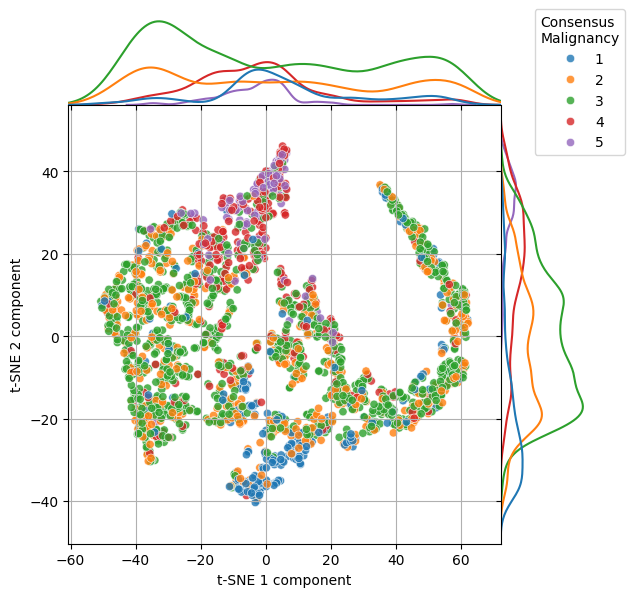

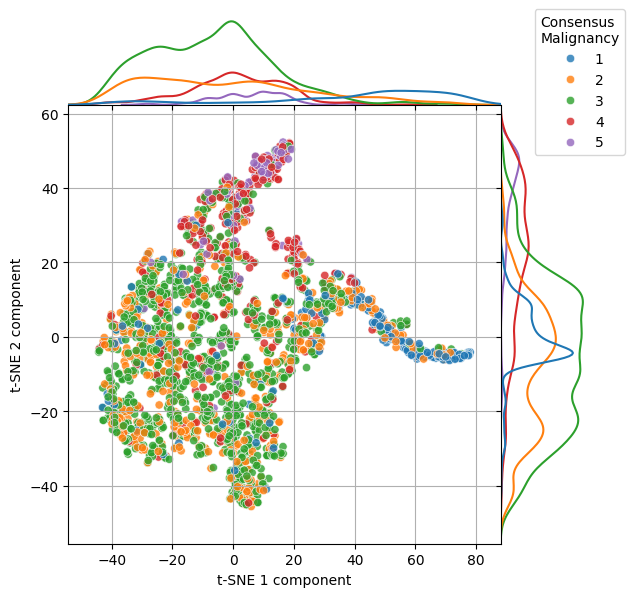

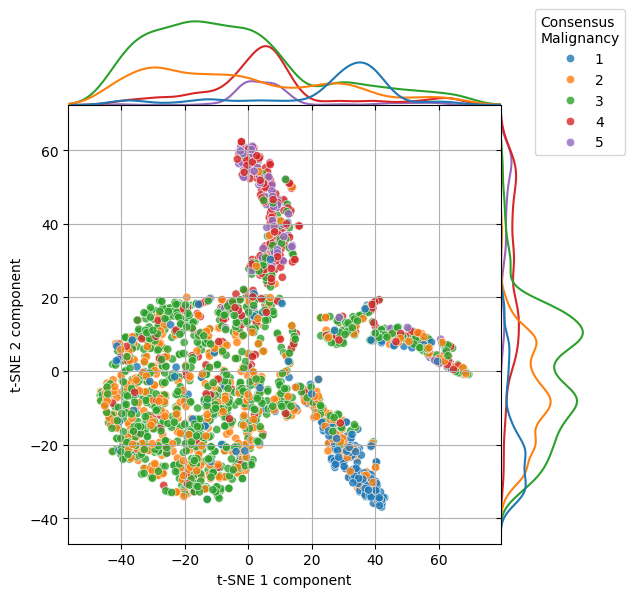

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# color_pallete = "RdYlBu"
# color_pallete = "YlGnBu"
color_pallete = "tab10"
nodule_df = pd.read_csv(nodule_processed_df_path)

# Plot params:
ratio = 5 # ratio of jointplot to scatterplot
height = 6 # height of the jointplot
padding = 10 # padding between scatterplot and jointplot
marginal_kws = {
   "fill": False,
   "bw_method": 0.2, # make the marginals more pointy
}

def plot_embeddings(embeddings_path: str) -> None:
    embeddings_25d = pd.read_csv(embeddings_path)
    embeddings_25d = pd.merge(embeddings_25d, nodule_df, on="nodule_id")

    # or "crest" color pallete
    g = sns.jointplot(data=embeddings_25d, x="x_embed", y="y_embed", hue="malignancy_consensus", alpha=0.8, palette=color_pallete, kind="scatter", height=height, ratio=ratio, space=0, marginal_kws=marginal_kws)
    x_min, x_max = embeddings_25d["x_embed"].min(), embeddings_25d["x_embed"].max()
    y_min, y_max = embeddings_25d["y_embed"].min(), embeddings_25d["y_embed"].max()

    plt.xlim(x_min - padding, x_max + padding)
    plt.xlabel("t-SNE 1 component")
    plt.ylabel("t-SNE 2 component")
    plt.ylim(y_min - padding, y_max + padding)

    plt.legend().remove()
    g.figure.legend(title="Consensus\nMalignancy", bbox_to_anchor=(1.05, 1))

    plt.grid(True)
    plt.show()

# C30 25D
plot_embeddings("model/embeddings/c30_25D_2411_1543/fold0/embeddings_df.csv")

# C50 25D
plot_embeddings("model/embeddings/c50_25D_2411_1812/fold0/embeddings_df.csv")

# C70 25D
plot_embeddings("model/embeddings/c70_25D_2411_1705/fold0/embeddings_df.csv")